In [2]:
from datetime import date as D
from datetime import datetime as DT
from datetime import timedelta
from matplotlib.font_manager import FontProperties
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import socketserver
import sqlite3
import sys
import threading
import time
import urllib.request
import requests

In [3]:
### CONFIG ###
PORT = 8000
SENSOR_UPDATE_INTERVAL = 60  # seconds
GRAPH_UPDATE_INTERVAL = 900  # 900s = 15m
sensor1ip = 'http://192.168.4.1:42000'
jsonfile = r"/var/www/html/projects/greenbox/greenbox.js"
phpfile = r"/var/www/html/projects/greenbox/graph.php"
graphfile = r"/var/www/html/projects/greenbox/graph.png"
palette = ['xkcd:sea blue', 'xkcd:leaf green', '#efa00b',
           '#d65108', '#591f0a', '#F7F7F7']

In [4]:
def timestamp(deltaHours=False): 
    if not deltaHours:
        return time.strftime("%Y-%m-%d %H:%M:%S") 
    else:
        newtime = DT.now() + timedelta(hours=i)
        return (newtime).strftime("%Y-%m-%d %H:%M:%S")

In [5]:
def writeJS(res, jsonfile):
    filetext = "var imgtag = \"<img src='projects/greenbox/graph.png?"
    filetext += str(int(time.time()))
    filetext += "' alt='Sensor Data (24h)'></img>\"\n"
    filetext += "document.getElementById('graphImg').innerHTML = imgtag\n"
    
    jsonStream = {x[0] : list(x[1:]) for x in res}
    filetext += json2js(jsonStream)
    
    with open (jsonfile, "w") as f:
        f.write(filetext)

In [6]:
def writePHP(phpfile):
    filetext = "<!-- graph.png -->\n"
    filetext += "<img src='projects/greenbox/graph.png?"
    filetext += str(int(time.time()))
    filetext += "' alt='Sensor Data (24h)'>\n"
    filetext += "<!-- /graph.png -->\n"
    
    with open(phpfile, "w") as f:
        f.write(filetext)
    

In [7]:
def json2js(sensor1):
    jsonString = "\njsonData = JSON.stringify(["
    jsonString += str(sensor1)
    jsonString += "]);\n"

    return jsonString

In [8]:
def dbinsert(jdata, c):
    if not (np.isnan(jdata["celsius"]) 
            or np.isnan(jdata["humidity"]) 
            or jdata["reservoir"] > 40 
            or jdata["ec"] <= 0 ):
        c.execute("INSERT INTO sensor1 VALUES " + 
                  ("('%s', %s, %s, %s, %s, %s, %s)" 
                  % (jdata['time'], jdata["celsius"], jdata["humidity"], 
                     jdata["heat index"], jdata["ph"], jdata["ec"], 
                     jdata["reservoir"])))
        return True

    else:
        print("%s\tReceived garbage data from sensor" % timestamp())
        return False



In [9]:
### Webserv ###
class Slave(threading.Thread):
    def run(self):
        self.kill = False
        self.ready = False
        import http.server
        Handler = http.server.SimpleHTTPRequestHandler
        try:
            httpd = socketserver.TCPServer(('0.0.0.0', PORT), Handler)
        except OSError as e:
            print (e)
            print("%s\tCaught socket exception, retrying..." % timestamp())
            time.sleep(10)
            self.run()

        self.ready = True

        while not self.kill:  # work hard until seppuku 
            httpd.handle_request()

        return

In [10]:
def read_sensor():
    try:
        req = requests.get(sensor1ip)
    except Exception as e:
        print(e)
        print("%s\tAn unknown error occurred, retrying..." % timestamp())
        time.sleep(10)
        return False

    if req.status_code is 200:
        jdata = req.json()
        print("%s temp:%s   humidity:%s  heat index:%s"
              % (timestamp(), jdata["celsius"],
                 jdata["humidity"], jdata["heat index"]))
        return jdata
    else:
        print("%s\tUnknown status code %d, retrying..."
              % (timestamp(), req.status_code))
        time.sleep(10)
        return False

In [11]:
def graph(c, debug=False, daterange=False):
    """
    [(0, 'time', 'datetime', 0, None, 0),
     (1, 'temp', 'float', 0, None, 0),
     (2, 'humidity', 'float', 0, None, 0),
     (3, 'heatindex', 'float', 0, None, 0),
     (4, 'ph', 'float', 0, None, 0),
     (5, 'ec', 'float', 0, None, 0),
     (6, 'reservoir', 'float', 0, None, 0)]
    """

    font = FontProperties()
    font.set_family('monospace')
    black = (0.0471,0.0701,0.0471)  # rgb
    
    if daterange is False:
        query = (r"SELECT * FROM sensor1 WHERE time BETWEEN "
                 + r"datetime('now', 'localtime', '-1 days') AND "
                 + r"datetime('now', 'localtime')")
    else:
        query = (r"SELECT * FROM sensor1 WHERE time BETWEEN "
                 + r"datetime('now', 'localtime', '" + str(daterange[0]) 
                 +" days') AND "
                 + r"datetime('now', 'localtime', '" + str(daterange[1])
                 + " days')")

    c.execute(query)
    res = np.array(c.fetchall())

    if len(res) < 10:
        print("%s\tNot enough recent data to make graph" % timestamp())
        return

    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 6))
    plt.suptitle("Sensor Data (24h)", y=1, fontproperties=font, fontsize=16, color=black)
    plt.subplots_adjust(hspace=0.5, top=0.85, bottom=0.1)
    dates = [DT.strptime(t, "%Y-%m-%d %H:%M:%S") for t in res[:,0]]
    hours = mdates.HourLocator(interval=2)
    mins = mdates.MinuteLocator(byminute=[0, 30])
    fmt = mdates.DateFormatter("%H:%M")
    
    axs[0].set_title("Temperature (*C)", fontproperties=font, color=black)
    axs[0].plot(dates, res[:, 1].astype(float), c=palette[3], label="Ambient", zorder=5)
    axs[0].fill_between(dates, res[:, 1].astype(float), alpha=0.5, color=palette[5], zorder=3)
    axs[0].fill_between(dates, res[:, 1].astype(float), alpha=0.2, color=palette[3], zorder=4)
    axs[0].plot(dates, res[:, 6].astype(float), c=palette[0], label="Reservoir", zorder=2)
    axs[0].fill_between(dates, res[:, 6].astype(float), alpha=0.27, color=palette[0], zorder=1)
    l = axs[0].legend()
    for text in l.get_texts():
        text.set_color("#0C120C")
    axs[0].set_ylim(20, 27.5)
    axs[1].set_title("Humidity (%)", fontproperties=font, color=black)
    axs[1].plot(dates, res[:, 2].astype(float), c=palette[0])
    axs[1].fill_between(dates, res[:, 2].astype(float), alpha=0.27, color=palette[0])
    axs[1].set_ylim(15, 80)
    axs[2].set_title("Power of Hydrogen (pH)", fontproperties=font, color=black)
    axs[2].plot(dates, res[:, 4].astype(float), c=palette[1])
    axs[2].fill_between(dates, res[:, 4].astype(float), alpha=0.24, color=palette[1])
    axs[2].set_ylim(4,8)
    axs[3].set_title("Conductivity (mS/cm)", fontproperties=font, color=black)
    axs[3].plot(dates, (res[:, 5].astype(float)), c=palette[2])
    axs[3].fill_between(dates, res[:, 5].astype(float), alpha=0.2, color=palette[2])
    axs[3].set_ylim(0, 2.25)
    
    for ax in axs:
        ax.grid()
        ax.xaxis.set_major_locator(hours)
        ax.xaxis.set_major_formatter(fmt)
        ax.xaxis.set_minor_locator(mins)
        ax.set_facecolor(palette[5])
        ax.tick_params(color=black, labelcolor=black)
        for spine in ax.spines.values():
            spine.set_edgecolor(black)

    today = D.strftime(D.today(), "%b %d, %Y")
    if debug:
        plt.xlabel("Time (%s debug=True)" % 
                   timestamp(), fontproperties=font, labelpad=20, color=black)
    else:
        plt.xlabel("Time (%s)" % 
                   today, fontproperties=font, labelpad=20, color=black)
    fig.autofmt_xdate()
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    if debug:
        plt.xlabel("Time (%s)" % 
                   today, fontproperties=font, labelpad=20, color=black)
        plt.show()
    else:
        plt.savefig(graphfile, facecolor=palette[5], edgecolor="red", dpi=150)
        plt.close()
        writeJS(res, jsonfile)
    
    return

In [12]:
#webslave = Slave()  # server to handle requests
#webslave.start()  # new thread
conn = sqlite3.connect("./sensordata.db")
c = conn.cursor()  # init db connection, pointer c

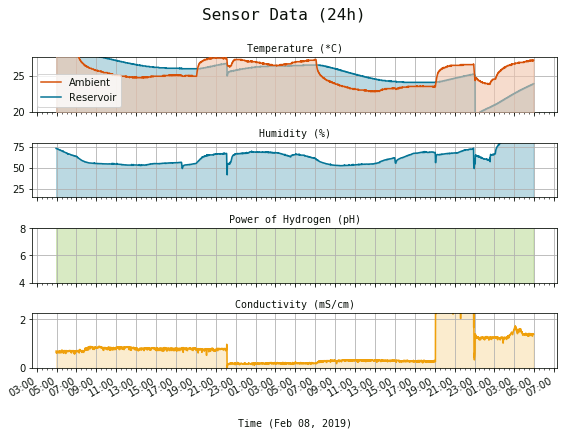

In [13]:
# this function is called once every 15m in the script
%matplotlib inline
palette = ['xkcd:sea blue', 'xkcd:leaf green', '#efa00b',
           '#d65108', '#591f0a', '#FFFFFF']
graph(c, debug=True, daterange=[-281, -279]) 

In [14]:
### main loop ###
def update(c, conn, webslave):
    sensor_sleeptime = 0
    graph_sleeptime = 0
    
    while(webslave.ready is False):
        print("%s\tWaiting for webslave..." % timestamp())
        time.sleep(10)

    while (True):
        jdata = read_sensor()
        if jdata is False: continue

        if not (np.isnan(jdata["celsius"]) or np.isnan(jdata["humidity"])):
            c.execute("INSERT INTO sensor1 VALUES ('%s', %s, %s)"
                      % (timestamp(), jdata["celsius"], jdata["humidity"]))
        else:
            print("%s\tReceived garbage data from sensor" % timestamp())

        if sensor_sleeptime == graph_sleeptime:
            conn.commit()
            graph(c)

        t = time.time()
        sensor_sleeptime = SENSOR_UPDATE_INTERVAL - ((t % SENSOR_UPDATE_INTERVAL))
        graph_sleeptime = GRAPH_UPDATE_INTERVAL - ((t % GRAPH_UPDATE_INTERVAL))
        time.sleep(sensor_sleeptime)

# Run through the operations of update(c, conn, webslave)



In [73]:
#print(webslave.ready)

We can provide some fake data while the sensor is not transmitting
Edit: recycle some old data instead

In [1]:
# While the controller is not transmitting, lets call up some old data 
%matplotlib inline

In [20]:
query = (r"SELECT * FROM sensor1 WHERE time BETWEEN "
             + r"datetime('now', 'localtime', '-365 days') AND "
             + r"datetime('now', 'localtime')")
c.execute(query)
res = np.array(c.fetchall())

In [147]:
res[0]


NameError: name 'res' is not defined

In [96]:
min(min([1, 2, 5, 6], [3]))

1

In [74]:
savefolder = r"/home/matt/Desktop/notebook-container/greenbox/scriptoutput"
%matplotlib inline

In [126]:
    def querygen(start="2018-03-20", stop="2018-05-03", interval=5):
        """
        Step <- minutes
        """

        start_tuple = time.strptime(start, '%Y-%m-%d')
        start_epoch = int(time.mktime(start_tuple))
        stop_tuple = time.strptime(stop, '%Y-%m-%d')
        stop_epoch = int(time.mktime(stop_tuple))
        step_epoch = (interval * 60)
        
        queries = []
        epochs = []
        
        for step in range(start_epoch, stop_epoch, step_epoch):
            nextstep = (step + (60 * 60 * 24))
            queries.append(r"SELECT * FROM sensor1 WHERE time BETWEEN "
                        + r"datetime(" + str(step) + ", 'unixepoch', 'localtime') AND "
                        + r"datetime(" + str(step) + ", 'unixepoch', 'localtime')")
            epochs.append(step)
        
        return np.array(queries), np.array(epochs)

In [148]:
queries, epochs = querygen()

In [154]:
dates = [time.strftime("%Y-%m-%d %H:%M:%d", time.localtime(x)) for x in epochs]
print(dates[0:10])

['2018-03-20 00:00:20', '2018-03-20 00:05:20', '2018-03-20 00:10:20', '2018-03-20 00:15:20', '2018-03-20 00:20:20', '2018-03-20 00:25:20', '2018-03-20 00:30:20', '2018-03-20 00:35:20', '2018-03-20 00:40:20', '2018-03-20 00:45:20']


In [180]:
print(f"{len(queries):05d}")

12672


In [61]:
def animate(c, start="2018-03-20", stop="2018-05-03", interval=72,
            #savefolder=r"/home/matt/Desktop/notebook-container/greenbox/scriptoutput", 
            savefolder=r"/var/www/html/projects/greenbox/scriptoutput",
            query=False, debug=False):
    """
    [(0, 'time', 'datetime', 0, None, 0),
     (1, 'temp', 'float', 0, None, 0),
     (2, 'humidity', 'float', 0, None, 0),
     (3, 'heatindex', 'float', 0, None, 0),
     (4, 'ph', 'float', 0, None, 0),
     (5, 'ec', 'float', 0, None, 0),
     (6, 'reservoir', 'float', 0, None, 0)]
    """

    font = FontProperties()
    font.set_family('monospace')
    black = (0.0471,0.0701,0.0471)  # rgb
    
    print("Querying...")
    
    def querygen(start="2018-03-23", stop="2018-04-07", interval=30):
        """
        Step <- minutes
        """

        start_tuple = time.strptime(start, '%Y-%m-%d')
        start_epoch = int(time.mktime(start_tuple))
        stop_tuple = time.strptime(stop, '%Y-%m-%d')
        stop_epoch = int(time.mktime(stop_tuple))
        step_epoch = (interval * 60)
        
        queries = []
        epochs = []
        
        for step in range(start_epoch, stop_epoch, step_epoch):
            nextstep = (step + (60 * 60 * 24 * 3))
            queries.append(r"SELECT * FROM sensor1 WHERE time BETWEEN "
                        + r"datetime(" + str(step) + ", 'unixepoch', 'localtime') AND "
                        + r"datetime(" + str(nextstep) + ", 'unixepoch', 'localtime')")
            epochs.append(step)
        
        return np.array(queries), np.array(epochs)
    
    queries, epochs = querygen()
    
    for ix in range(len(queries)):
        
        #if ix > 10:
        #    break
        
        graphfile = savefolder + r"/" + f"{ix:05d}" + ".png"
        c.execute(queries[ix])
        res = np.array(c.fetchall())

        if len(res) < (60 * 24 * 3 - 5):
            #print("%s\tNot enough recent data to make graph" % timestamp())
            print(str(len(res)) + " < " + str(60 * 24 * 3 - 5) + ", skipping " + str(ix))
            continue

        fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 6))
        plt.suptitle("Sensor Data (24h)", y=1, fontproperties=font, fontsize=16, color=black)
        plt.subplots_adjust(hspace=0.5, top=0.85, bottom=0.1)
        dates = [DT.strptime(t, "%Y-%m-%d %H:%M:%S") for t in res[:,0]]
        #hours = mdates.HourLocator(interval=24)
        #mins = mdates.MinuteLocator(byminute=[0, 30])
        hours = mdates.DayLocator(bymonthday=[0, 7, 14, 21, 28])
        mins = mdates.DayLocator()
        #fmt = mdates.DateFormatter("%H:%M")
        fmt = mdates.DateFormatter("%Y-%m-%d")

        axs[0].set_title("Temperature (*C)", fontproperties=font, color=black)
        axs[0].plot(dates, res[:, 1].astype(float), c=palette[3], label="Ambient", zorder=5)
        axs[0].fill_between(dates, res[:, 1].astype(float), alpha=0.5, color=palette[5], zorder=3)
        axs[0].fill_between(dates, res[:, 1].astype(float), alpha=0.2, color=palette[3], zorder=4)
        axs[0].plot(dates, res[:, 6].astype(float), c=palette[0], label="Reservoir", zorder=2)
        axs[0].fill_between(dates, res[:, 6].astype(float), alpha=0.27, color=palette[0], zorder=1)
        
        
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        
        
        l = axs[0].legend(bbox_to_anchor=[0.1, 0.5], loc="center")
        for text in l.get_texts():
            text.set_color("#0C120C")
        axs[0].set_ylim(20, 27.5)
        axs[1].set_title("Humidity (%)", fontproperties=font, color=black)
        axs[1].plot(dates, res[:, 2].astype(float), c=palette[0])
        axs[1].fill_between(dates, res[:, 2].astype(float), alpha=0.27, color=palette[0])
        axs[1].set_ylim(15, 80)
        axs[2].set_title("Power of Hydrogen (pH)", fontproperties=font, color=black)
        axs[2].plot(dates, res[:, 4].astype(float), c=palette[1])
        axs[2].fill_between(dates, res[:, 4].astype(float), alpha=0.24, color=palette[1])
        axs[2].set_ylim(4,8)
        axs[3].set_title("Conductivity (mS/cm)", fontproperties=font, color=black)
        axs[3].plot(dates, (res[:, 5].astype(float)), c=palette[2])
        axs[3].fill_between(dates, res[:, 5].astype(float), alpha=0.2, color=palette[2])
        axs[3].set_ylim(0, 3)

        for ax in axs:
            ax.grid()
            ax.xaxis.set_major_locator(hours)
            ax.xaxis.set_major_formatter(fmt)
            ax.xaxis.set_minor_locator(mins)
            ax.set_facecolor(palette[5])
            ax.tick_params(color=black, labelcolor=black)
            for spine in ax.spines.values():
                spine.set_edgecolor(black)

        #today = D.strftime(D.today(), "%b %d, %Y")
        
        today = time.strftime("%Y-%m-%d", time.localtime(epochs[ix]))
        
        plt.xlabel("Time (%s)" % today, fontproperties=font, labelpad=20, color=black)
        fig.autofmt_xdate()
        fig.tight_layout(rect=[0, 0, 1, 0.94])
        print("saving " + graphfile + " / " + f"{len(queries)}")
        plt.savefig(graphfile, facecolor=palette[5], edgecolor="red", dpi=150)
        plt.close()
    
    return

In [ ]:
import imageio

In [146]:


#batchAnimate(c)

savefolder = r"/var/www/html/projects/greenbox/scriptoutput/"
imgs = []
for (dirpath, dirnames, filenames) in os.walk(savefolder):
    imgs.extend(filenames)
    break

imgs.sort()
outimgs = []
for img in imgs:
    img = savefolder + img
    #print(img)
    outimgs.append(imageio.imread(img))
imageio.mimsave((savefolder + "data.gif"), outimgs, fps=20)
print("done")

done


In [144]:

def batchAnimate(c, batchsize=4000,
                #savefolder=r"/home/matt/Desktop/notebook-container/greenbox/scriptoutput", 
                savefolder=r"/var/www/html/projects/greenbox/scriptoutput",
                query=False, debug=False):
    """
    [(0, 'time', 'datetime', 0, None, 0),
     (1, 'temp', 'float', 0, None, 0),
     (2, 'humidity', 'float', 0, None, 0),
     (3, 'heatindex', 'float', 0, None, 0),
     (4, 'ph', 'float', 0, None, 0),
     (5, 'ec', 'float', 0, None, 0),
     (6, 'reservoir', 'float', 0, None, 0)]
    """

    font = FontProperties()
    font.set_family('monospace')
    black = (0.0471,0.0701,0.0471)  # rgb
    
    print("Querying...")
    
    query = (r"SELECT * FROM sensor1")# WHERE time BETWEEN "
   #             + r"datetime(" + str(step) + ", 'unixepoch', 'localtime') AND "
   #             + r"datetime(" + str(nextstep) + ", 'unixepoch', 'localtime')")
    c.execute(query)
    result = np.array(c.fetchall())
    
    ixcounter = 0;
    
    for ix in range(0, len(result), int(batchsize/25)):
        res = result[ix:ix+batchsize]
        ixcounter += 1
        
        if ix > (44000 - 320):
            break
        
        graphfile = savefolder + r"/" + f"{ixcounter:05d}" + ".png"


        if len(res) < (4000):
            #print("%s\tNot enough recent data to make graph" % timestamp())
            print(str(len(res)) + " < " + str(60 * 24 * 3 - 5) + ", skipping " + graphfile)
            continue

        fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 6))
        plt.suptitle("Sensor Data", y=1, fontproperties=font, fontsize=16, color=black)
        plt.subplots_adjust(hspace=0.5, top=0.85, bottom=0.1)
        dates = [DT.strptime(t, "%Y-%m-%d %H:%M:%S") for t in res[:,0]]
        #hours = mdates.HourLocator(interval=24)
        #mins = mdates.MinuteLocator(byminute=[0, 30])
        hours = mdates.DayLocator()
        mins = mdates.DayLocator()
        #fmt = mdates.DateFormatter("%H:%M")
        fmt = mdates.DateFormatter("%Y-%m-%d")

        axs[0].set_title("Temperature (*C)", fontproperties=font, color=black)
        axs[0].plot(dates, res[:, 1].astype(float), c=palette[3], label="Ambient", zorder=5)
        axs[0].fill_between(dates, res[:, 1].astype(float), alpha=0.5, color=palette[5], zorder=3)
        axs[0].fill_between(dates, res[:, 1].astype(float), alpha=0.2, color=palette[3], zorder=4)
        axs[0].plot(dates, res[:, 6].astype(float), c=palette[0], label="Reservoir", zorder=2)
        axs[0].fill_between(dates, res[:, 6].astype(float), alpha=0.27, color=palette[0], zorder=1)
        l = axs[0].legend(bbox_to_anchor=[0.1, 0.5], loc="center")
        for text in l.get_texts():
            text.set_color("#0C120C")
        axs[0].set_ylim(20, 27.5)
        axs[1].set_title("Humidity (%)", fontproperties=font, color=black)
        axs[1].plot(dates, res[:, 2].astype(float), c=palette[0])
        axs[1].fill_between(dates, res[:, 2].astype(float), alpha=0.27, color=palette[0])
        axs[1].set_ylim(15, 80)
        axs[2].set_title("Power of Hydrogen (pH)", fontproperties=font, color=black)
        axs[2].plot(dates, res[:, 4].astype(float), c=palette[1])
        axs[2].fill_between(dates, res[:, 4].astype(float), alpha=0.24, color=palette[1])
        axs[2].set_ylim(4,8)
        axs[3].set_title("Conductivity (mS/cm)", fontproperties=font, color=black)
        axs[3].plot(dates, (res[:, 5].astype(float)), c=palette[2])
        axs[3].fill_between(dates, res[:, 5].astype(float), alpha=0.2, color=palette[2])
        axs[3].set_ylim(0, 3)

        for ax in axs:
            ax.grid()
#            ax.xaxis.set_major_locator(hours)
            ax.xaxis.set_major_formatter(fmt)
            ax.xaxis.set_minor_locator(mins)
            ax.tick_params(labelbottom=False)
            ax.set_facecolor(palette[5])
            ax.tick_params(color=black, labelcolor=black)
            for spine in ax.spines.values():
                spine.set_edgecolor(black)
                

        #today = D.strftime(D.today(), "%b %d, %Y")
        #print(res[0][0])
        today = res[0][0][0:10]
        #today = D.strftime(time.localtime(str(res[0][0])), "%Y-%m-%d")
        
        plt.xlabel("Time: week of %s" % today, fontproperties=font, labelpad=20, color=black)
        fig.autofmt_xdate()
        fig.tight_layout(rect=[0, 0, 1, 0.94])
        print("saving " + graphfile)
        plt.savefig(graphfile, facecolor=palette[5], edgecolor="red", dpi=150)
        plt.close()
    
    return

In [119]:
    query = (r"SELECT * FROM sensor1")# WHERE time BETWEEN "
   #             + r"datetime(" + str(step) + ", 'unixepoch', 'localtime') AND "
   #             + r"datetime(" + str(nextstep) + ", 'unixepoch', 'localtime')")
    c.execute(query)
    result = np.array(c.fetchall())
    


In [138]:
result[47000][0][0:10]

'2018-04-14'